simulated data csv success!


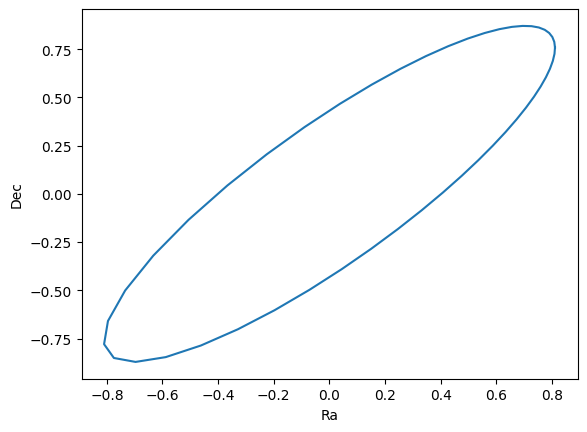

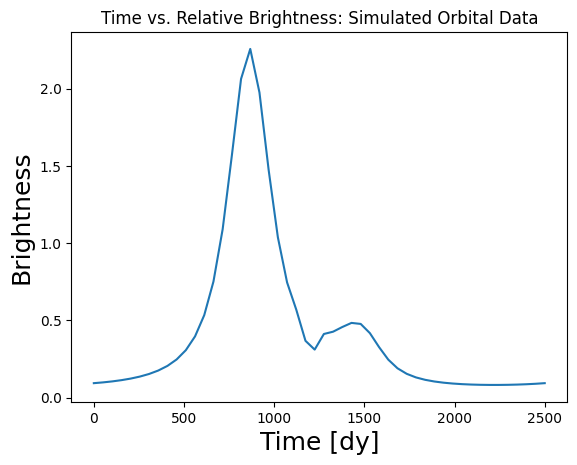

In [13]:
# Toy Model: Converting orbital elements to position
import numpy as np
import math
import matplotlib.pyplot as plt

# First define functions:

#Here will be the function where we convert time to mean anomaly; we will convert these 5 values:
time_values = np.linspace(0, 2500, num=50)

# We can begin defining the conversion and its variables
# t0 is time since periapsis (when its closest to the star) , t is the current time, T is orbital period, a is semi-major axis
def time_to_mean_anomaly(t, t0 = 1200, T = 2500):

# This is the equation to go from time to mean anomaly
   mean_anomaly = (2 * math.pi * (t-t0)/T)
   return mean_anomaly
    

mean_anomaly = time_to_mean_anomaly(time_values, T = 2500, t0 = 1200)
mean_anomalies = []
for i in time_values:
    mean_anomaly = time_to_mean_anomaly(i, 1200, 2500)
    mean_anomalies.append(mean_anomaly)


# print out the final answer as a statement
#for i, mean_anomaly in enumerate(mean_anomalies):
    #print(f"Time: {time_values[i]} degrees --> Mean Anomaly: {math.degrees(mean_anomaly)} degrees --> Eccentric Anomaly: {math.degrees(Ecc_anomalies_list[i])} degrees")


# Define mean anomaly to eccentric anomaly
def mean_to_eccentric(mean_anomaly, e):
    #Here is where we convert from mean anomaly to eccentric anomanly
    E = mean_anomaly

# Solution to keplers equation is below: M = E - e * sin(E), which turns into f(E) = M + e *sin(E)
    max_iterations = 50
    tolerance = 1e-9

    for _ in range(max_iterations):

        E_new = E - (E - e * np.sin(E) - mean_anomaly) / (1 - e * np.cos(E))
        if abs(E_new - E) < tolerance:
            break
        E = E_new
        

    return E
Ecc_anomalies_list = []
for i in mean_anomalies:
    E =  mean_to_eccentric(i,0.3)
    Ecc_anomalies_list.append(E)
#print("These are the eccentric anomalies:", Ecc_anomalies_list)

# Convert from eccentric anomaly to true anomaly
def eccentric_to_true(E, e):

# Calculate tan(f/2)
    tan_f_over_2 = math.sqrt((1 + e) / (1 - e)) * math.tan(E / 2)
    
    # Calculate ν
    f = 2 * math.atan(tan_f_over_2)
    
    #make sure nu is within [0, 2π)
    if f < 0:
        f += 2 * math.pi
    
    return f
true_anomalies = []
for i in Ecc_anomalies_list:
    f = eccentric_to_true(i, 0.3)
    true_anomalies.append(f)
#print("These are the true anomalies:", true_anomalies)

#print("These are the orbital positions:", orbital_elements_and_true_anomaly_to_positions)

def orbital_elements_and_true_anomaly_to_positions(f, r = 0.9,e = 0.75,inc = np.radians(30), Omega = np.radians(60), omega = np.radians(120), plx = np.radians(65)):
    # Write the converting function
    ra = r*(np.cos(Omega)*np.cos(omega + f) - np.sin(Omega)*np.sin(omega + f)*np.cos(inc))
    dec = r*(np.sin(Omega)*np.cos(omega + f) - np.cos(Omega)*np.sin(omega + f)*np.cos(inc))
    a = plx*r
    Albedo= 0.5
    
    R = (a*(1-e**2))/(1+e*np.cos(f))
        
    z = int(R)*(-np.cos(omega)*np.sin(inc)*np.sin(f)-np.cos(f)*np.sin(inc)*np.sin(omega))
        
    ro = (z**2+((ra**2+dec**2)/plx**2))**0.5
        
    B = math.atan2(-ro, z)+ math.pi
        
    A = (1/math.pi)*(np.sin(B)+(math.pi-B)*np.cos(B))
        
    brightness = Albedo*A/ro**2
        
    return ra, dec, brightness
r = 0.9
e = 0.3
inc = np.radians(30)
Omega = np.radians(60)
omega = np.radians(120)
plx = np.radians(90)

oe_to_pos_ra = []
oe_to_pos_dec = []
brightness_new = []
for i in true_anomalies:
    ra, dec, brightness = orbital_elements_and_true_anomaly_to_positions(i, r, e, inc, Omega, omega, plx)

    oe_to_pos_ra.append(ra)
    oe_to_pos_dec.append(dec)
    brightness_new.append(brightness)

#print("These are the true anomalies:", true_anomalies)

#print("These are the orbital positions:", orbital_elements_and_true_anomaly_to_positions)

#print("These are the orbital positions!", oe_to_pos)

# print out the final answer as a statement
#for i, mean_anomaly in enumerate(mean_anomalies):
    #print(f"Time: {time_values[i]} degrees --> Mean Anomaly: {math.degrees(mean_anomaly)} degrees --> Eccentric Anomaly: {math.degrees(Ecc_anomalies_list[i])} degrees")

# Now lets plot the ra and dec values
#print(oe_to_pos_ra)
#print(oe_to_pos_dec)

plt.figure()
plt.plot(oe_to_pos_ra, oe_to_pos_dec)
plt.xlabel('Ra')
plt.ylabel('Dec')

plt.figure()
plt.plot(time_values, brightness_new)
plt.xlabel("Time [dy]", fontsize=18)
plt.ylabel("Brightness", fontsize=18)
plt.title("Time vs. Relative Brightness: Simulated Orbital Data")

import csv

# Assuming you already have ra, dec, brightness, and time (as epoch)
# oe_to_pos_ra, oe_to_pos_dec, brightness_new, and time_values lists exist

#CSV file name
#filename = "/Users/farrahamolina/orbitize/orbitize/example_data/orbital_data_with_id.csv"
filename = "/Users/farrahamolina/orbitize/orbitize/example_data/simulated_ra_dec_data.csv"
Object_ID_List = [1] * 50
raoff_err_list = [0.01] * 50
decoff_err_list = [0.01] * 50

#with open(filename, mode='w', newline='') as file:
 #   writer = csv.writer(file)

    # Write the header with the additional "object_id" column
  #  writer.writerow(["epoch", "object", "raoff", "decoff", "raoff_err", "decoff_err", "brightness"])

    # Write the data rows with a unique ID for each object
   # for (epoch, obj, ra, dec, raoff_err, decoff_err, brightness) in (zip(time_values, Object_ID_List, oe_to_pos_ra, oe_to_pos_dec, raoff_err_list, decoff_err_list,  brightness_new)):
    #    writer.writerow([epoch, obj, ra, dec, raoff_err,decoff_err, brightness])

#print("csv file success!!")

with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header with the additional "object_id" column
    writer.writerow(["epoch", "object", "raoff", "decoff", "raoff_err", "decoff_err"])

    # Write the data rows with a unique ID for each object
    for (epoch, obj, ra, dec, raoff_err, decoff_err) in (zip(time_values, Object_ID_List, oe_to_pos_ra, oe_to_pos_dec, raoff_err_list, decoff_err_list)):
        writer.writerow([epoch, obj, ra, dec, raoff_err,decoff_err])

print("simulated data csv success!")



